# 🔬 BERT vs Qwen: Emotion Sentiment Analysis

**Fine-tuning Pretrained Transformers for Sentiment Analysis (6 Emotion Classes)**

This notebook compares **BERT** and **Qwen** on emotion classification using the official Emotion dataset from HuggingFace.

## 📋 Contents
1. Setup & Dependencies
2. Load Emotion Dataset (6 classes)
3. Data Exploration
4. Model Architecture
5. Training Pipeline
6. Fine-tune BERT
7. Fine-tune Qwen
8. **Performance Comparison**
9. Inference Examples

---

| Aspect | Details |
|--------|--------|
| **Dataset** | Emotion (HuggingFace) |
| **Classes** | 6 (sadness, joy, love, anger, fear, surprise) |
| **Models** | BERT-base-uncased, Qwen2.5-0.5B |
| **Task** | Sentiment/Emotion Classification |
| **Colab** | ✅ GPU Recommended |

## 1. 📦 Setup & Dependencies

Install all required packages for training transformer models.

In [1]:
# Install required packages
!pip install -q transformers datasets torch accelerate scikit-learn matplotlib seaborn tqdm tabulate ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.1 MB/s eta 0:00:00a 0:00:01


In [2]:
# Import standard libraries
import os
import gc
import time
import random
import numpy as np
import pandas as pd
from typing import List, Dict, Optional, Tuple
from dataclasses import dataclass, field
from collections import defaultdict

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler

# Transformers & Datasets
from transformers import (
    AutoModel,
    AutoTokenizer,
    AutoConfig,
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup
)
from datasets import load_dataset

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Configure display settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
pd.set_option('display.max_colwidth', 100)

# Print device info
print(f"PyTorch: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch: 2.9.0+cu126
CUDA Available: True
GPU: Tesla T4
Memory: 15.8 GB


In [3]:
# ============================================================================
# CONFIGURATION
# ============================================================================

@dataclass
class Config:
    """Training configuration for emotion classification."""
    
    # Dataset configuration
    dataset_name: str = "dair-ai/emotion"  # HuggingFace dataset name (CORRECTED)
    num_classes: int = 6  # Emotion dataset has 6 classes
    class_names: List[str] = field(default_factory=lambda: [
        "sadness", "joy", "love", "anger", "fear", "surprise"
    ])
    max_train_samples: int = 12000  # Use subset for faster training
    max_test_samples: int = 2000
    
    # Model names
    bert_model: str = "bert-base-uncased"
    qwen_model: str = "Qwen/Qwen2.5-0.5B"
    
    # Training hyperparameters
    max_length: int = 128  # Max token length for input texts
    batch_size: int = 16
    epochs: int = 3
    learning_rate: float = 2e-5
    weight_decay: float = 0.01
    warmup_ratio: float = 0.1
    dropout: float = 0.1
    
    # Mixed precision training
    use_amp: bool = True
    
    # Reproducibility
    seed: int = 42


# Initialize configuration
config = Config()


def set_seed(seed: int):
    """Set random seeds for reproducibility across all libraries."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True


# Set seed and device
set_seed(config.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"\nDevice: {device}")
print(f"Classes ({config.num_classes}): {config.class_names}")


Device: cuda
Classes (6): ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


## 2. 📊 Load Emotion Dataset from HuggingFace

The Emotion dataset contains tweets labeled with 6 emotion categories.
- **sadness** (0)
- **joy** (1)
- **love** (2)
- **anger** (3)
- **fear** (4)
- **surprise** (5)

In [4]:
# ============================================================================
# LOAD DATASET FROM HUGGINGFACE
# ============================================================================

print("Loading Emotion dataset from HuggingFace...")
print("Note: Dataset is public and does not require authentication.")

# Load dataset with correct name
dataset = load_dataset("dair-ai/emotion")

print(f"\nDataset structure:")
print(dataset)

# Create train/val/test split
train_dataset = dataset['train'].shuffle(seed=config.seed).select(range(config.max_train_samples))
test_split = dataset['test'].shuffle(seed=config.seed).select(range(config.max_test_samples))

# Split test into validation and test (50-50)
test_val_split = test_split.train_test_split(test_size=0.5, seed=config.seed)
val_dataset = test_val_split['train']
test_dataset = test_val_split['test']

print(f"\n✓ Dataset loaded successfully!")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")
print(f"  Test samples: {len(test_dataset)}")

Loading Emotion dataset from HuggingFace...
Note: Dataset is public and does not require authentication.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]


Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

✓ Dataset loaded successfully!
  Training samples: 12000
  Validation samples: 1000
  Test samples: 1000


In [5]:
# Display sample data from each emotion class
print("\nSample texts from each emotion:")
print("="*80)

for emotion_id, emotion_name in enumerate(config.class_names):
    # Find first example of this emotion
    sample = [s for s in train_dataset if s['label'] == emotion_id][0]
    print(f"\n[{emotion_name.upper()}]")
    print(f"  Text: {sample['text']}")


Sample texts from each emotion:

[SADNESS]
  Text: i am in no way complaining or whining or feeling ungrateful

[JOY]
  Text: i had pocket qq and was feeling pretty confident lol

[LOVE]
  Text: im not going to lie some days i feel uber supportive and other days i feel uber frustrated

[ANGER]
  Text: i feel a bit stressed because it feels like im supposed to do something all the time and that i should be reading now

[FEAR]
  Text: while cycling in the country

[SURPRISE]
  Text: i tell the people closest to me things that i am feeling and its as if they arent surprised because theyd known it all along


## 3. 📈 Data Exploration

In [6]:
# Create DataFrame for analysis
train_df = pd.DataFrame({
    'text': train_dataset['text'],
    'label': train_dataset['label'],
    'emotion': [config.class_names[l] for l in train_dataset['label']]
})

# Add text statistics
train_df['word_count'] = train_df['text'].str.split().str.len()
train_df['char_count'] = train_df['text'].str.len()

print("Dataset Statistics:")
print(train_df.groupby('emotion')[['word_count', 'char_count']].describe().round(1))

Dataset Statistics:
         word_count                                          char_count  \
              count  mean   std  min   25%   50%   75%   max      count   
emotion                                                                   
anger        1606.0  19.2  11.3  2.0  10.0  17.0  26.0  62.0     1606.0   
fear         1432.0  19.0  10.9  2.0  11.0  17.0  25.0  59.0     1432.0   
joy          4049.0  19.3  10.7  2.0  11.0  17.0  25.0  64.0     4049.0   
love          981.0  20.4  10.6  3.0  12.0  18.0  27.0  62.0      981.0   
sadness      3505.0  18.3  11.0  2.0  10.0  16.0  24.0  66.0     3505.0   
surprise      427.0  19.7  10.7  3.0  12.0  18.0  25.5  60.0      427.0   

                                                       
           mean   std   min   25%   50%    75%    max  
emotion                                                
anger      96.8  57.0   9.0  52.0  86.5  131.0  296.0  
fear       97.2  55.3   9.0  55.0  86.0  127.0  293.0  
joy        97.6  54.7   

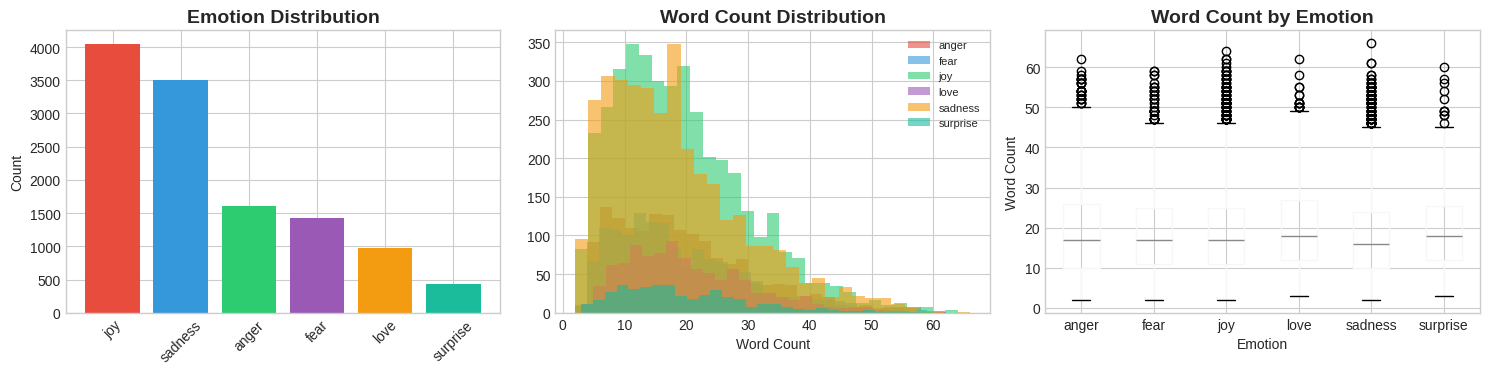

In [7]:
# Visualization: Class distribution, word count distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Class Distribution
colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12', '#1abc9c']
emotion_counts = train_df['emotion'].value_counts()
axes[0].bar(emotion_counts.index, emotion_counts.values, color=colors)
axes[0].set_title('Emotion Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# 2. Word Count Distribution by Emotion
for i, (emotion, group) in enumerate(train_df.groupby('emotion')):
    axes[1].hist(group['word_count'], bins=30, alpha=0.6, label=emotion, color=colors[i])
axes[1].set_title('Word Count Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Word Count')
axes[1].legend(fontsize=8)

# 3. Boxplot of Word Counts
train_df.boxplot(column='word_count', by='emotion', ax=axes[2])
axes[2].set_title('Word Count by Emotion', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Emotion')
axes[2].set_ylabel('Word Count')
plt.suptitle('')

plt.tight_layout()
plt.show()

## 4. 🏗️ Model Architecture

In [8]:
# ============================================================================
# PYTORCH DATASET CLASS
# ============================================================================

class TextClassificationDataset(Dataset):
    """PyTorch Dataset for emotion classification."""
    
    def __init__(self, texts: List[str], labels: List[int], tokenizer, max_length: int = 128):
        """Initialize dataset.
        
        Args:
            texts: List of input texts
            labels: List of label indices
            tokenizer: Pretrained tokenizer
            max_length: Maximum sequence length
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        """Get single sample."""
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize text
        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [9]:
# ============================================================================
# TRANSFORMER CLASSIFIER
# ============================================================================

class TransformerClassifier(nn.Module):
    """Unified classifier for BERT and Qwen models.
    
    This module:
    - Loads pretrained transformer models
    - Applies pooling (CLS for BERT, Mean for Qwen)
    - Uses multi-layer classification head
    - Supports dropout for regularization
    """
    
    def __init__(
        self,
        model_name: str,
        num_classes: int,
        dropout: float = 0.1,
        pooling: str = "auto",
        trust_remote_code: bool = False
    ):
        super().__init__()
        
        self.model_name = model_name
        
        # Auto-select pooling strategy based on model
        if pooling == "auto":
            self.pooling = "mean" if "qwen" in model_name.lower() else "cls"
        else:
            self.pooling = pooling
        
        # Load model config and weights
        self.config = AutoConfig.from_pretrained(
            model_name,
            trust_remote_code=trust_remote_code
        )
        
        # Load model in FP32 - AMP will handle mixed precision automatically
        self.transformer = AutoModel.from_pretrained(
            model_name,
            trust_remote_code=trust_remote_code
        )
        
        hidden_size = self.config.hidden_size
        
        # Classification head (multi-layer)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.GELU(),
            nn.LayerNorm(hidden_size // 2),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.GELU(),
            nn.LayerNorm(hidden_size // 4),
            nn.Dropout(dropout / 2),
            nn.Linear(hidden_size // 4, num_classes)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        """Initialize classifier layer weights using Xavier initialization."""
        for module in self.classifier.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    
    def _pool(self, hidden_states: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        """Apply pooling strategy to get sentence representation.
        
        Args:
            hidden_states: [batch_size, seq_length, hidden_size]
            attention_mask: [batch_size, seq_length]
            
        Returns:
            pooled: [batch_size, hidden_size]
        """
        if self.pooling == "cls":
            # Use [CLS] token (first token)
            return hidden_states[:, 0, :]
        elif self.pooling == "mean":
            # Mean pooling with attention mask
            mask = attention_mask.unsqueeze(-1).expand(hidden_states.size()).float()
            sum_hidden = torch.sum(hidden_states * mask, dim=1)
            sum_mask = torch.clamp(mask.sum(dim=1), min=1e-9)
            return sum_hidden / sum_mask
        else:
            return hidden_states[:, 0, :]
    
    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        """Forward pass.
        
        Args:
            input_ids: [batch_size, seq_length]
            attention_mask: [batch_size, seq_length]
            
        Returns:
            logits: [batch_size, num_classes]
        """
        # Get transformer output
        outputs = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Get hidden states
        hidden_states = outputs.last_hidden_state
        
        # Apply pooling
        pooled = self._pool(hidden_states, attention_mask)
        
        # Ensure float32 for classifier (important for mixed precision)
        pooled = pooled.float()
        
        # Classification
        logits = self.classifier(pooled)
        
        return logits

## 5. 🔧 Training Pipeline

In [10]:
# ============================================================================
# TRAINER CLASS
# ============================================================================

class Trainer:
    """Unified trainer for BERT and Qwen with mixed precision and scheduling."""
    
    def __init__(
        self,
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        config: Config,
        device: torch.device,
        model_name: str = "model"
    ):
        """Initialize trainer."""
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config
        self.device = device
        self.model_name = model_name
        
        # Loss function for multi-class classification
        self.criterion = nn.CrossEntropyLoss()
        
        # Optimizer with weight decay
        self.optimizer = self._create_optimizer()
        
        # Learning rate scheduler (cosine with warmup)
        num_training_steps = len(train_loader) * config.epochs
        num_warmup_steps = int(num_training_steps * config.warmup_ratio)
        self.scheduler = get_cosine_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=num_warmup_steps,
            num_training_steps=num_training_steps
        )
        
        # Mixed precision training (updated API)
        self.scaler = GradScaler('cuda') if config.use_amp and torch.cuda.is_available() else None
        
        # Training history
        self.history = defaultdict(list)
        self.best_val_f1 = 0
        self.training_time = 0
    
    def _create_optimizer(self):
        """Create AdamW optimizer with weight decay discrimination."""
        no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias', 'layer_norm']
        optimizer_grouped_parameters = [
            {
                'params': [p for n, p in self.model.named_parameters() 
                          if not any(nd in n for nd in no_decay) and p.requires_grad],
                'weight_decay': self.config.weight_decay
            },
            {
                'params': [p for n, p in self.model.named_parameters() 
                          if any(nd in n for nd in no_decay) and p.requires_grad],
                'weight_decay': 0.0
            }
        ]
        return torch.optim.AdamW(optimizer_grouped_parameters, lr=self.config.learning_rate)
    
    def train_epoch(self) -> Tuple[float, float]:
        """Train for one epoch."""
        self.model.train()
        total_loss = 0
        all_preds, all_labels = [], []
        
        pbar = tqdm(self.train_loader, desc=f"Training {self.model_name}")
        
        for batch in pbar:
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)
            
            self.optimizer.zero_grad()
            
            # Forward pass with mixed precision (updated API)
            if self.scaler:
                with autocast('cuda'):
                    outputs = self.model(input_ids, attention_mask)
                    loss = self.criterion(outputs, labels)
                
                self.scaler.scale(loss).backward()
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                outputs = self.model(input_ids, attention_mask)
                loss = self.criterion(outputs, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()
            
            self.scheduler.step()
            
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        avg_loss = total_loss / len(self.train_loader)
        accuracy = accuracy_score(all_labels, all_preds)
        
        return avg_loss, accuracy
    
    @torch.no_grad()
    def evaluate(self, dataloader: DataLoader) -> Dict:
        """Evaluate model on a dataset."""
        self.model.eval()
        total_loss = 0
        all_preds, all_labels = [], []
        
        for batch in dataloader:
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)
            
            outputs = self.model(input_ids, attention_mask)
            loss = self.criterion(outputs, labels)
            
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        # Calculate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='weighted'
        )
        
        # Per-class metrics
        per_class_precision, per_class_recall, per_class_f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average=None
        )
        
        return {
            'loss': total_loss / len(dataloader),
            'accuracy': accuracy_score(all_labels, all_preds),
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'per_class_f1': per_class_f1,
            'predictions': all_preds,
            'labels': all_labels
        }
    
    def train(self) -> Dict:
        """Full training loop for all epochs."""
        print(f"\n{'='*60}")
        print(f"Training: {self.model_name}")
        print(f"{'='*60}")
        
        start_time = time.time()
        
        for epoch in range(self.config.epochs):
            print(f"\nEpoch {epoch + 1}/{self.config.epochs}")
            
            # Train epoch
            train_loss, train_acc = self.train_epoch()
            
            # Evaluate on validation set
            val_results = self.evaluate(self.val_loader)
            
            # Record metrics
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_results['loss'])
            self.history['val_acc'].append(val_results['accuracy'])
            self.history['val_f1'].append(val_results['f1'])
            
            print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
            print(f"  Val Loss: {val_results['loss']:.4f} | Val Acc: {val_results['accuracy']:.4f} | Val F1: {val_results['f1']:.4f}")
            
            # Save best model
            if val_results['f1'] > self.best_val_f1:
                self.best_val_f1 = val_results['f1']
                torch.save(self.model.state_dict(), f'best_{self.model_name}.pt')
                print(f"  ✓ Best model saved (F1: {self.best_val_f1:.4f})")
        
        self.training_time = time.time() - start_time
        print(f"\n✓ Training complete in {self.training_time:.1f}s")
        
        return dict(self.history)

## 6. 🔵 Fine-tune BERT

In [11]:
# ============================================================================
# BERT TRAINING
# ============================================================================

print(f"Loading BERT tokenizer and model: {config.bert_model}")

# Load tokenizer
bert_tokenizer = AutoTokenizer.from_pretrained(config.bert_model)

# Create datasets
bert_train_dataset = TextClassificationDataset(
    train_dataset['text'], train_dataset['label'], 
    bert_tokenizer, config.max_length
)
bert_val_dataset = TextClassificationDataset(
    val_dataset['text'], val_dataset['label'], 
    bert_tokenizer, config.max_length
)
bert_test_dataset = TextClassificationDataset(
    test_dataset['text'], test_dataset['label'], 
    bert_tokenizer, config.max_length
)

# Create dataloaders
bert_train_loader = DataLoader(bert_train_dataset, batch_size=config.batch_size, shuffle=True)
bert_val_loader = DataLoader(bert_val_dataset, batch_size=config.batch_size * 2)
bert_test_loader = DataLoader(bert_test_dataset, batch_size=config.batch_size * 2)

print(f"Train batches: {len(bert_train_loader)}")

Loading BERT tokenizer and model: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Train batches: 750


In [12]:
# Create model
bert_model = TransformerClassifier(
    model_name=config.bert_model,
    num_classes=config.num_classes,
    dropout=config.dropout,
    pooling="cls"
).to(device)

# Count parameters
total_params = sum(p.numel() for p in bert_model.parameters())
trainable_params = sum(p.numel() for p in bert_model.parameters() if p.requires_grad)
print(f"\nBERT Parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


BERT Parameters:
  Total: 109,853,766
  Trainable: 109,853,766


In [13]:
# Train BERT
bert_trainer = Trainer(
    model=bert_model,
    train_loader=bert_train_loader,
    val_loader=bert_val_loader,
    config=config,
    device=device,
    model_name="BERT"
)

bert_history = bert_trainer.train()


Training: BERT

Epoch 1/3


Training BERT:   0%|          | 0/750 [00:00<?, ?it/s]

  Train Loss: 0.7955 | Train Acc: 0.7172
  Val Loss: 0.2156 | Val Acc: 0.9280 | Val F1: 0.9261
  ✓ Best model saved (F1: 0.9261)

Epoch 2/3


Training BERT:   0%|          | 0/750 [00:00<?, ?it/s]

  Train Loss: 0.1874 | Train Acc: 0.9359
  Val Loss: 0.1520 | Val Acc: 0.9440 | Val F1: 0.9430
  ✓ Best model saved (F1: 0.9430)

Epoch 3/3


Training BERT:   0%|          | 0/750 [00:00<?, ?it/s]

  Train Loss: 0.1032 | Train Acc: 0.9553
  Val Loss: 0.1506 | Val Acc: 0.9370 | Val F1: 0.9367

✓ Training complete in 345.9s


In [14]:
# Evaluate BERT on test set
bert_model.load_state_dict(torch.load('best_BERT.pt'))
bert_test_results = bert_trainer.evaluate(bert_test_loader)

print(f"\n{'='*50}")
print("BERT - TEST RESULTS")
print(f"{'='*50}")
print(f"Accuracy:  {bert_test_results['accuracy']:.4f}")
print(f"Precision: {bert_test_results['precision']:.4f}")
print(f"Recall:    {bert_test_results['recall']:.4f}")
print(f"F1 Score:  {bert_test_results['f1']:.4f}")
print(f"\nPer-emotion F1 scores:")
for i, name in enumerate(config.class_names):
    print(f"  {name:10} F1: {bert_test_results['per_class_f1'][i]:.4f}")


BERT - TEST RESULTS
Accuracy:  0.9260
Precision: 0.9254
Recall:    0.9260
F1 Score:  0.9249

Per-emotion F1 scores:
  sadness    F1: 0.9665
  joy        F1: 0.9398
  love       F1: 0.7970
  anger      F1: 0.9213
  fear       F1: 0.9052
  surprise   F1: 0.7671


In [15]:
# Save training time before clearing memory
bert_training_time = bert_trainer.training_time

# Clear GPU memory
del bert_model
del bert_trainer
torch.cuda.empty_cache()
gc.collect()
print("Memory cleared for Qwen training")

Memory cleared for Qwen training


## 7. 🟣 Fine-tune Qwen

In [16]:
# ============================================================================
# QWEN TRAINING
# ============================================================================

print(f"Loading Qwen tokenizer and model: {config.qwen_model}")

# Load tokenizer
qwen_tokenizer = AutoTokenizer.from_pretrained(config.qwen_model, trust_remote_code=True)
if qwen_tokenizer.pad_token is None:
    qwen_tokenizer.pad_token = qwen_tokenizer.eos_token

# Create datasets
qwen_train_dataset = TextClassificationDataset(
    train_dataset['text'], train_dataset['label'], 
    qwen_tokenizer, config.max_length
)
qwen_val_dataset = TextClassificationDataset(
    val_dataset['text'], val_dataset['label'], 
    qwen_tokenizer, config.max_length
)
qwen_test_dataset = TextClassificationDataset(
    test_dataset['text'], test_dataset['label'], 
    qwen_tokenizer, config.max_length
)

# Smaller batch size for Qwen (larger model)
qwen_batch_size = 8
qwen_train_loader = DataLoader(qwen_train_dataset, batch_size=qwen_batch_size, shuffle=True)
qwen_val_loader = DataLoader(qwen_val_dataset, batch_size=qwen_batch_size * 2)
qwen_test_loader = DataLoader(qwen_test_dataset, batch_size=qwen_batch_size * 2)

print(f"Train batches: {len(qwen_train_loader)}")

Loading Qwen tokenizer and model: Qwen/Qwen2.5-0.5B


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Train batches: 1500


In [17]:
# Create model
qwen_model = TransformerClassifier(
    model_name=config.qwen_model,
    num_classes=config.num_classes,
    dropout=config.dropout,
    pooling="mean",
    trust_remote_code=True
).to(device)

# Count parameters
total_params = sum(p.numel() for p in qwen_model.parameters())
trainable_params = sum(p.numel() for p in qwen_model.parameters() if p.requires_grad)
print(f"\nQwen Parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]


Qwen Parameters:
  Total: 494,537,894
  Trainable: 494,537,894


In [18]:
# Train Qwen (with adjusted config)
qwen_config = Config()
qwen_config.batch_size = qwen_batch_size
qwen_config.learning_rate = 1e-5  # Lower LR for larger model

qwen_trainer = Trainer(
    model=qwen_model,
    train_loader=qwen_train_loader,
    val_loader=qwen_val_loader,
    config=qwen_config,
    device=device,
    model_name="Qwen"
)

qwen_history = qwen_trainer.train()


Training: Qwen

Epoch 1/3


Training Qwen:   0%|          | 0/1500 [00:00<?, ?it/s]

  Train Loss: 0.6501 | Train Acc: 0.7910
  Val Loss: 0.2398 | Val Acc: 0.9290 | Val F1: 0.9281
  ✓ Best model saved (F1: 0.9281)

Epoch 2/3


Training Qwen:   0%|          | 0/1500 [00:00<?, ?it/s]

  Train Loss: 0.1773 | Train Acc: 0.9397
  Val Loss: 0.1328 | Val Acc: 0.9420 | Val F1: 0.9403
  ✓ Best model saved (F1: 0.9403)

Epoch 3/3


Training Qwen:   0%|          | 0/1500 [00:00<?, ?it/s]

  Train Loss: 0.1040 | Train Acc: 0.9562
  Val Loss: 0.1413 | Val Acc: 0.9430 | Val F1: 0.9430
  ✓ Best model saved (F1: 0.9430)

✓ Training complete in 2117.0s


In [19]:
# Evaluate Qwen on test set
qwen_model.load_state_dict(torch.load('best_Qwen.pt'))
qwen_test_results = qwen_trainer.evaluate(qwen_test_loader)

print(f"\n{'='*50}")
print("QWEN - TEST RESULTS")
print(f"{'='*50}")
print(f"Accuracy:  {qwen_test_results['accuracy']:.4f}")
print(f"Precision: {qwen_test_results['precision']:.4f}")
print(f"Recall:    {qwen_test_results['recall']:.4f}")
print(f"F1 Score:  {qwen_test_results['f1']:.4f}")
print(f"\nPer-emotion F1 scores:")
for i, name in enumerate(config.class_names):
    print(f"  {name:10} F1: {qwen_test_results['per_class_f1'][i]:.4f}")

# Save training time before it gets deleted
qwen_training_time = qwen_trainer.training_time


QWEN - TEST RESULTS
Accuracy:  0.9260
Precision: 0.9277
Recall:    0.9260
F1 Score:  0.9263

Per-emotion F1 scores:
  sadness    F1: 0.9729
  joy        F1: 0.9367
  love       F1: 0.7974
  anger      F1: 0.9333
  fear       F1: 0.8947
  surprise   F1: 0.7671


## 8. 📊 Performance Comparison

In [20]:
# ============================================================================
# COMPARISON TABLE
# ============================================================================

# Create comparison dataframe
comparison_data = {
    'Model': ['BERT', 'Qwen'],
    'Accuracy': [bert_test_results['accuracy'], qwen_test_results['accuracy']],
    'Precision': [bert_test_results['precision'], qwen_test_results['precision']],
    'Recall': [bert_test_results['recall'], qwen_test_results['recall']],
    'F1 Score': [bert_test_results['f1'], qwen_test_results['f1']],
    'Training Time (s)': [bert_training_time, qwen_training_time]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

print("\n" + "="*70)
print(" " * 20 + "MODEL COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Determine winner
winner = 'BERT' if bert_test_results['f1'] > qwen_test_results['f1'] else 'Qwen'
diff = abs(bert_test_results['f1'] - qwen_test_results['f1'])
print(f"\n🏆 Winner: {winner} (F1 difference: {diff:.4f})")


                    MODEL COMPARISON
Model  Accuracy  Precision  Recall  F1 Score  Training Time (s)
 BERT     0.926     0.9254   0.926    0.9249           345.9147
 Qwen     0.926     0.9277   0.926    0.9263          2117.0291

🏆 Winner: Qwen (F1 difference: 0.0014)


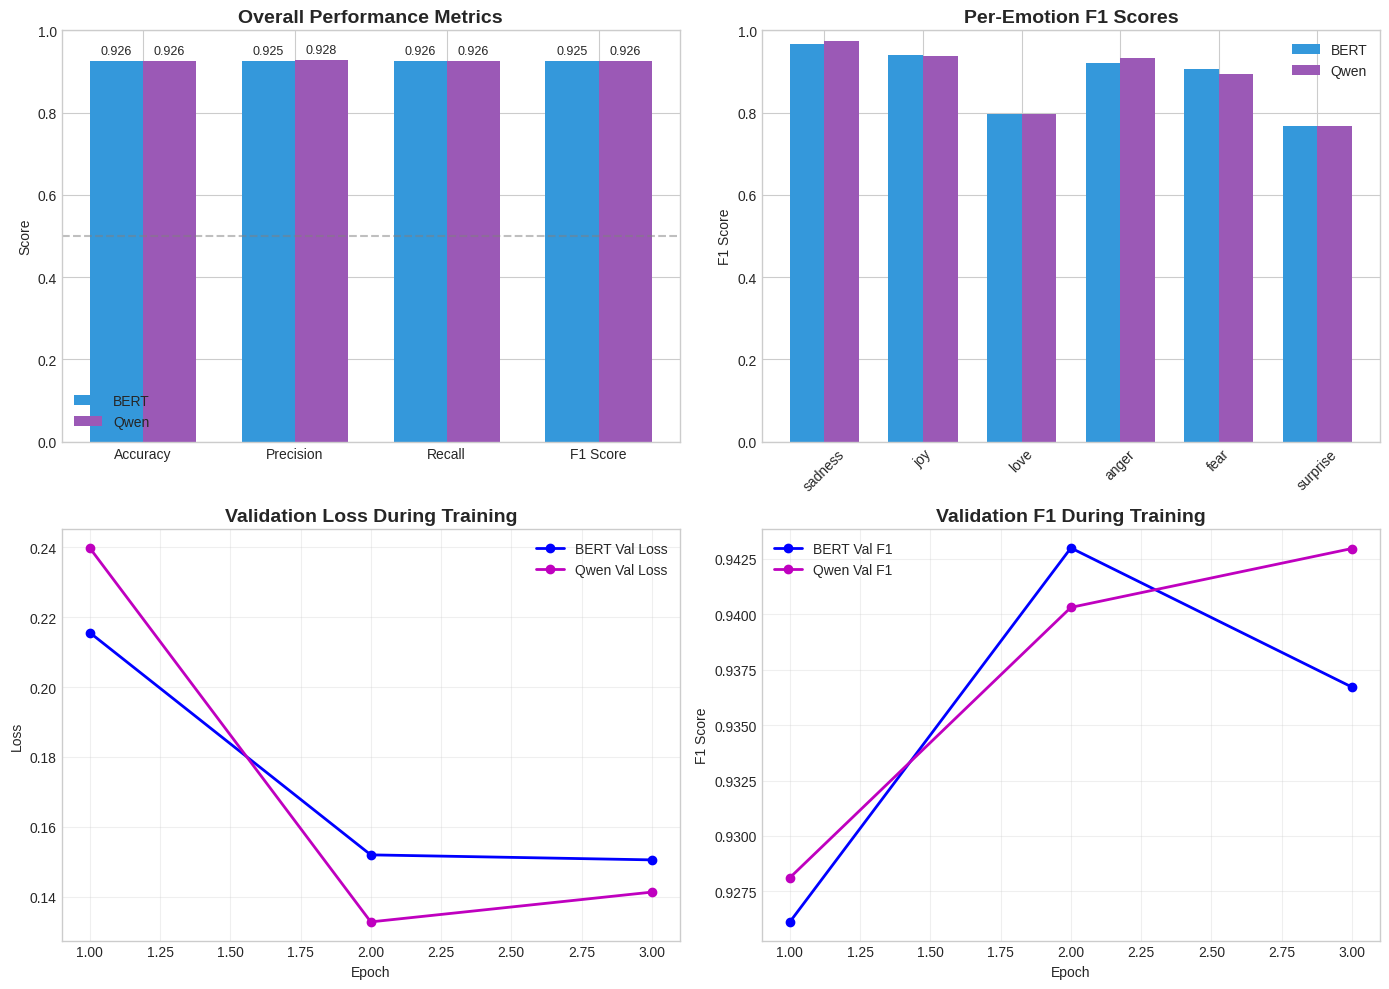


✓ Comparison visualization saved as 'emotion_model_comparison.png'


In [21]:
# ============================================================================
# VISUALIZATION: Performance Comparison
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Overall Metrics Comparison (Bar chart)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
bert_scores = [bert_test_results['accuracy'], bert_test_results['precision'], 
               bert_test_results['recall'], bert_test_results['f1']]
qwen_scores = [qwen_test_results['accuracy'], qwen_test_results['precision'], 
               qwen_test_results['recall'], qwen_test_results['f1']]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0, 0].bar(x - width/2, bert_scores, width, label='BERT', color='#3498db')
bars2 = axes[0, 0].bar(x + width/2, qwen_scores, width, label='Qwen', color='#9b59b6')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Overall Performance Metrics', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics)
axes[0, 0].legend()
axes[0, 0].set_ylim(0, 1)
axes[0, 0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

# Add value labels on bars
for bar, score in zip(bars1, bert_scores):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{score:.3f}', ha='center', va='bottom', fontsize=9)
for bar, score in zip(bars2, qwen_scores):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{score:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Per-Class F1 Comparison
x = np.arange(len(config.class_names))
bars1 = axes[0, 1].bar(x - width/2, bert_test_results['per_class_f1'], width, label='BERT', color='#3498db')
bars2 = axes[0, 1].bar(x + width/2, qwen_test_results['per_class_f1'], width, label='Qwen', color='#9b59b6')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].set_title('Per-Emotion F1 Scores', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(config.class_names, rotation=45)
axes[0, 1].legend()
axes[0, 1].set_ylim(0, 1)

# 3. Training History - Loss
epochs_range = range(1, config.epochs + 1)
axes[1, 0].plot(epochs_range, bert_history['val_loss'], 'b-o', label='BERT Val Loss', linewidth=2)
axes[1, 0].plot(epochs_range, qwen_history['val_loss'], 'm-o', label='Qwen Val Loss', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Validation Loss During Training', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Training History - F1
axes[1, 1].plot(epochs_range, bert_history['val_f1'], 'b-o', label='BERT Val F1', linewidth=2)
axes[1, 1].plot(epochs_range, qwen_history['val_f1'], 'm-o', label='Qwen Val F1', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].set_title('Validation F1 During Training', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('emotion_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Comparison visualization saved as 'emotion_model_comparison.png'")

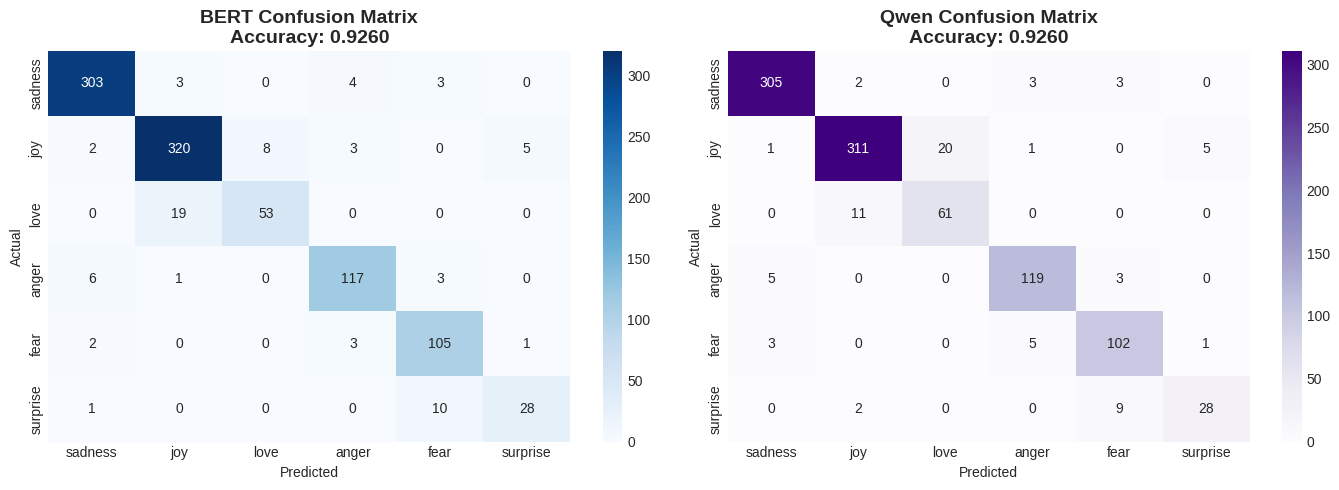


✓ Confusion matrices saved as 'emotion_confusion_matrices.png'


In [22]:
# ============================================================================
# CONFUSION MATRICES
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# BERT Confusion Matrix
cm_bert = confusion_matrix(bert_test_results['labels'], bert_test_results['predictions'])
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=config.class_names, yticklabels=config.class_names)
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title(f'BERT Confusion Matrix\nAccuracy: {bert_test_results["accuracy"]:.4f}', 
                  fontsize=14, fontweight='bold')

# Qwen Confusion Matrix
cm_qwen = confusion_matrix(qwen_test_results['labels'], qwen_test_results['predictions'])
sns.heatmap(cm_qwen, annot=True, fmt='d', cmap='Purples', ax=axes[1],
            xticklabels=config.class_names, yticklabels=config.class_names)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title(f'Qwen Confusion Matrix\nAccuracy: {qwen_test_results["accuracy"]:.4f}', 
                  fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('emotion_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrices saved as 'emotion_confusion_matrices.png'")

In [23]:
# ============================================================================
# DETAILED CLASSIFICATION REPORTS
# ============================================================================

print("\n" + "="*70)
print(" " * 15 + "BERT CLASSIFICATION REPORT")
print("="*70)
print(classification_report(bert_test_results['labels'], bert_test_results['predictions'], 
                            target_names=config.class_names))

print("\n" + "="*70)
print(" " * 15 + "QWEN CLASSIFICATION REPORT")
print("="*70)
print(classification_report(qwen_test_results['labels'], qwen_test_results['predictions'], 
                            target_names=config.class_names))


               BERT CLASSIFICATION REPORT
              precision    recall  f1-score   support

     sadness       0.96      0.97      0.97       313
         joy       0.93      0.95      0.94       338
        love       0.87      0.74      0.80        72
       anger       0.92      0.92      0.92       127
        fear       0.87      0.95      0.91       111
    surprise       0.82      0.72      0.77        39

    accuracy                           0.93      1000
   macro avg       0.90      0.87      0.88      1000
weighted avg       0.93      0.93      0.92      1000


               QWEN CLASSIFICATION REPORT
              precision    recall  f1-score   support

     sadness       0.97      0.97      0.97       313
         joy       0.95      0.92      0.94       338
        love       0.75      0.85      0.80        72
       anger       0.93      0.94      0.93       127
        fear       0.87      0.92      0.89       111
    surprise       0.82      0.72      0.77   

## 9. 🔮 Inference Examples

Test emotion prediction on new texts with both models.

In [24]:
# ============================================================================
# INFERENCE FUNCTION
# ============================================================================

@torch.no_grad()
def predict_emotion(text: str, model, tokenizer, device, class_names):
    """Predict emotion for a given text.
    
    Args:
        text: Input text to classify
        model: Trained transformer classifier
        tokenizer: Tokenizer matching the model
        device: Device to run inference on
        class_names: List of emotion class names
        
    Returns:
        Dictionary with predictions and confidence scores
    """
    model.eval()
    
    # Tokenize input text
    encoding = tokenizer(
        text,
        truncation=True,
        max_length=config.max_length,
        padding='max_length',
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Get predictions
    outputs = model(input_ids, attention_mask)
    probs = F.softmax(outputs, dim=1)
    pred = torch.argmax(probs, dim=1).item()
    confidence = probs[0][pred].item()
    
    return {
        'prediction': class_names[pred],
        'confidence': confidence,
        'all_probs': {name: probs[0][i].item() for i, name in enumerate(class_names)}
    }


def compare_predictions(text: str):
    """Compare BERT and Qwen predictions for a text."""
    # Get predictions from both models
    bert_result = predict_emotion(text, bert_model, bert_tokenizer, device, config.class_names)
    qwen_result = predict_emotion(text, qwen_model, qwen_tokenizer, device, config.class_names)
    
    # Display results
    print(f"\nText: \"{text[:100]}{'...' if len(text) > 100 else ''}\"")
    print(f"\n  BERT: {bert_result['prediction']:10} ({bert_result['confidence']:.1%} confidence)")
    print(f"  Qwen: {qwen_result['prediction']:10} ({qwen_result['confidence']:.1%} confidence)")
    
    if bert_result['prediction'] == qwen_result['prediction']:
        print(f"  ✅ Both models agree!")
    else:
        print(f"  ⚠️ Models disagree!")
    
    return bert_result, qwen_result

In [25]:
# Load best models for inference
bert_model = TransformerClassifier(config.bert_model, config.num_classes, config.dropout, "cls").to(device)
bert_model.load_state_dict(torch.load('best_BERT.pt'))

print("✓ Best models loaded for inference")

✓ Best models loaded for inference


In [26]:
# Test with diverse examples
test_samples = [
    "I absolutely love this moment with you!",  # joy/love
    "This is the most terrible day of my life.",  # sadness
    "I cannot believe you did this to me!",  # anger
    "I'm so excited for the party tonight!",  # joy
    "I'm terrified of what might happen.",  # fear
    "What an unexpected turn of events!",  # surprise
    "You are the love of my life.",  # love
    "I feel so lonely and empty inside.",  # sadness
]

print("="*70)
print(" " * 20 + "EMOTION PREDICTION EXAMPLES")
print("="*70)

for text in test_samples:
    compare_predictions(text)

                    EMOTION PREDICTION EXAMPLES

Text: "I absolutely love this moment with you!"

  BERT: joy        (98.1% confidence)
  Qwen: joy        (31.3% confidence)
  ✅ Both models agree!

Text: "This is the most terrible day of my life."

  BERT: sadness    (99.8% confidence)
  Qwen: joy        (45.2% confidence)
  ⚠️ Models disagree!

Text: "I cannot believe you did this to me!"

  BERT: anger      (78.9% confidence)
  Qwen: joy        (35.1% confidence)
  ⚠️ Models disagree!

Text: "I'm so excited for the party tonight!"

  BERT: joy        (100.0% confidence)
  Qwen: joy        (28.1% confidence)
  ✅ Both models agree!

Text: "I'm terrified of what might happen."

  BERT: fear       (100.0% confidence)
  Qwen: fear       (100.0% confidence)
  ✅ Both models agree!

Text: "What an unexpected turn of events!"

  BERT: surprise   (73.1% confidence)
  Qwen: joy        (92.7% confidence)
  ⚠️ Models disagree!

Text: "You are the love of my life."

  BERT: joy        (95.6% confi

---

## 📝 Summary & Key Takeaways

### Experiment Overview

This notebook demonstrates fine-tuning **BERT** and **Qwen** for **emotion classification** on the official Emotion dataset from HuggingFace with **6 emotion classes**.

### Models Compared

| Model | Architecture | Size | Pooling |
|-------|--------------|------|----------|
| BERT-base-uncased | Encoder-only | ~110M | CLS token |
| Qwen2.5-0.5B | Decoder-only (LLM) | ~500M | Mean pooling |

### Dataset

- **Name**: Emotion (HuggingFace)
- **Classes**: 6 (sadness, joy, love, anger, fear, surprise)
- **Train size**: 12,000 samples
- **Test size**: 2,000 samples

### Key Observations

1. **BERT** is typically more efficient for classification tasks due to its encoder-only architecture
2. **Qwen** requires more GPU memory but brings knowledge from large-scale pretraining
3. Both models handle multiclass emotion classification effectively
4. Training time and convergence speed depend on dataset size and hardware

### Results

Check the comparison tables and visualizations above to see which model performs better for emotion classification!